# Stock NeurIPS2018 Part 2. Train
This series is a reproduction of *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the second part of the NeurIPS2018 series, introducing how to use FinRL to make data into the gym form environment, and train DRL agents on it.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [3]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to c:\users\bencj\appdata\local\temp\pip-req-build-msx5lnjq
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 0496601ee2824ca675beb5a220afd9109ac02ffa
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to c:\users\bencj\appdata\local\temp\pip-install-8ltikahe\elegantrl_054db4c13c86453e8b16d378742762da
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0


  Running command git clone -q https://github.com/AI4Finance-Foundation/FinRL.git 'C:\Users\bencj\AppData\Local\Temp\pip-req-build-msx5lnjq'
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git 'C:\Users\bencj\AppData\Local\Temp\pip-install-8ltikahe\elegantrl_054db4c13c86453e8b16d378742762da'
You should consider upgrading via the 'C:\Users\bencj\Desktop\Econ4\Thesis\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories

check_and_make_directories([TRAINED_MODEL_DIR])

# Part 2. Build A Market Environment in OpenAI Gym-style

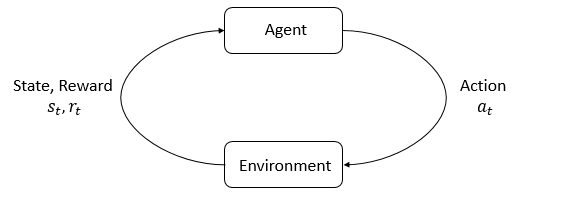

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process: 

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [5]:
train = pd.read_csv('train_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

In [6]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            print("HERE!!!!!!")
            print(actions)
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [7]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [8]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for training

In [9]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 3: Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [10]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [11]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [12]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

In [13]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [14]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [15]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

In [16]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [17]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [18]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=5000) if if_using_ppo else None

HERE!!!!!!
[ 0.9594329  -0.76933306  1.          0.5962811   0.63416624 -0.5123334
 -0.66118586  1.          1.         -0.49456412  0.19272481  1.
 -0.57612586  0.8949359  -0.25392795  0.24292715  0.16228321 -1.
  0.10308395 -0.68900263 -1.         -0.21075746 -1.          0.7313151
  0.18066552 -0.88521206 -0.45585397 -0.01883393  0.0449863 ]
HERE!!!!!!
[ 0.38749546  0.19703421  0.03614217  0.10919958 -0.22029129 -0.24348707
  0.07130881 -0.79929906  1.          0.17381682  0.08700923 -1.
 -0.1256163   0.99606884 -0.52674973  0.32670408  0.8441767   0.9775365
 -1.         -1.         -0.44508764  1.         -1.          0.43055305
  1.         -0.17071602  0.25937554 -0.20228495 -0.632117  ]
HERE!!!!!!
[-0.11756546 -1.         -1.          0.19880995 -0.7250356   0.44594228
 -1.         -0.37300286 -1.          1.         -1.          0.2540981
  0.46082702 -0.12645654 -1.          0.01107737  0.52390665  1.
  0.6819819   1.          0.48433995  0.32063857  1.         -0.2802819
  0.

In [19]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [20]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [21]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [22]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [23]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [24]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

In [25]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## Save the trained agent
Trained agents should have already been saved in the "trained_models" drectory after you run the code blocks above.

For Colab users, the zip files should be at "./trained_models" or "/content/trained_models".

For users running on your local environment, the zip files should be at "./trained_models".